# Adaptive PDE discretizations on cartesian grids 
## Volume : GPU accelerated methods
## Part : Eikonal equations, acceleration and reproducibility
## Chapter : Forward and reverse differentiation

We compute the geodesic flow and minimal geodesics, on the CPU and GPU, checking for consistency.

## 0. Importing the required libraries

In [7]:
import sys; sys.path.insert(0,"../..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Isotropic_Repro','GPU'))

In [8]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [9]:
from agd import HFMUtils
from agd import AutomaticDifferentiation as ad
from agd import Metrics
from agd import FiniteDifferences as fd
import agd.AutomaticDifferentiation.cupy_generic as cugen
norm_infinity = ad.Optimization.norm_infinity
from agd.HFMUtils import RunGPU,RunSmart

In [10]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global HFMUtils,ad,cugen,RunGPU
    HFMUtils,ad,cugen,RunGPU = rreload([HFMUtils,ad,cugen,RunGPU],"../..")    

In [11]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)
RunSmart = cugen.cupy_get_args(RunSmart,dtype64=True,iterables=(dict,Metrics.Base))

In [12]:
def RunCompare(gpuIn,check=True):
    gpuOut = RunGPU(gpuIn)
    if gpuIn.get('verbosity',1): print("---")
    cpuOut = RunSmart(gpuIn)
    print("Max |gpuValues-cpuValues| : ", norm_infinity(gpuOut['values'].get()-cpuOut['values']))
    cpuTime = cpuOut['FMCPUTime']; gpuTime = gpuOut['solverGPUTime'];
    print(f"Solver time (s). GPU : {gpuTime}, CPU : {cpuTime}. Device acceleration : {cpuTime/gpuTime}")
    assert not check or cp.allclose(gpuOut['values'],cpuOut['values'],atol=1e-6)
    return gpuOut,cpuOut

## 1. Isotropic metrics

In [472]:
ReloadPackages()

In [13]:
n=50
hfmIn = HFMUtils.dictIn({
    'model':'Isotropic2',
    'seeds':cp.array([[0.,0.],[1.,1.]]),
    'exportValues':1,
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
X=hfmIn.Grid()

Casting output of function array from float64 to float32


In [14]:
#delta1 = ad.Dense.identity(constant=cp.zeros(1))
#cost1 = 1.+delta1[0]*(X[0]>0.1)
delta = ad.Dense.identity(constant=cp.zeros(2))
hfmIn['cost']=1.+delta[0]*(X[0]>0.) + delta[1]*(X[0]<=0)
hfmIn['seedValues']=ad.array([delta[0],0.2+delta[1]])

Casting output of function zeros from float64 to float32


In [15]:
hfmOut = RunGPU(hfmIn)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)


TypeError: no implementation found for 'numpy.pad' on types that implement __array_function__: [<class 'agd.AutomaticDifferentiation.Dense.denseAD_cupy'>]

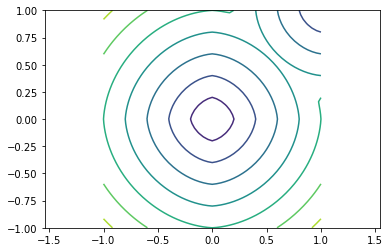

In [476]:
plt.axis('equal')
plt.contour(*X,hfmOut['values'])

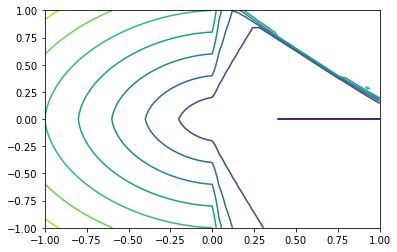

In [479]:
plt.contour(*X,hfmOut['valueVariation'][:,:,1]);

In [465]:
np.min(np.abs(hfmOut['valueVariation'][:,:,0]))

array(2.82e-15)

In [271]:
cp.expand_dims(cp.zeros(2),axis=-1)

Casting output of function zeros from float64 to float32


array([[    0],
       [    0]], dtype=float32)

In [26]:
import cupy

In [29]:
cupy.cupyx.scipy.sparse

<module 'cupyx.scipy.sparse' from 'C:\\Users\\Shadow\\Miniconda3\\envs\\gpuenv\\lib\\site-packages\\cupyx\\scipy\\sparse\\__init__.py'>

In [13]:
arr = np.arange(6).reshape(2,3)
pos = arr[0]>1
arr[0,pos]=-1

In [14]:
arr

array([[ 0,  1, -1],
       [ 3,  4,  5]])